# Hipótesis 3

In [1]:
! pip install scikit-learn
! pip install numpy==1.25.2
! pip install pandas==2.0.3
! pip install seaborn==0.12.2
! pip install optuna==3.4.0



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\mohae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\mohae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\mohae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\mohae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\mohae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import os 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import optuna
ruta_actual = os.getcwd()
directorio_superior = os.path.dirname(ruta_actual)
sys.path.append(directorio_superior)
from Acceso_BBDD.MetodosBBDD import *


C:\Users\mohae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir(directorio_superior)
df_hipotesis3 = obtener_dataframe_sql('Hipotesis_3', GOLD)

En esta hipótesis explicaremos si se puede predecir las ventas de vehículos eléctricos en base a las condiciones del país para adaptar la tecnología eléctrica.  Estas características que mediremos son: puntos de carga de vehículos eléctricos y el precio de la electricidad en el país. 

## Tarjeta de datos

La primera característica que hemos observado en los datos es que cada país representa una serie temporal a la hora de vender vehículos. Es decir, existen progresiones en las ventas en un mismo país con el paso de los años, por tanto, hemos añadido una nueva columna llamada Sells_last_year. Si bien es cierto que nuestro dataset es corto, ya que únicamente contamos con las ventas de 5 años (2017 a 2022), creemos que sacrificar un año para poder representar esta nueva columna puede ser de interés a la hora de predecir el número de ventas. 

## Codificación Variables Categóricas

Uno de los primeros problemas que nos encontramos son las variables categóricas, en este caso, Country y Type_Vehicle, que representan el país y el tipo de vehículo si bien es híbrido o eléctrico.
Realizaremos una codificación con LabelEncoder, de manera que cada país y tipo de vehículo representará un valor distinto.

In [4]:
def Codificacion_var_categoricas(dataframe):
    df = dataframe.copy()
    label_encoder = LabelEncoder()
    df['Country'] = label_encoder.fit_transform(df['Country'])
    for clase, valor in enumerate(label_encoder.classes_):
        print(f"El valor asignado para '{clase}' es {valor}")
    df['Type_Vehicle'] = label_encoder.fit_transform(df['Type_Vehicle'])
    for clase, valor in enumerate(label_encoder.classes_):
        print(f"El valor asignado para '{clase}' es {valor}")
    return df

dataframe_h3 = Codificacion_var_categoricas(df_hipotesis3)

El valor asignado para '0' es Austria
El valor asignado para '1' es Belgium
El valor asignado para '2' es Denmark
El valor asignado para '3' es Finland
El valor asignado para '4' es France
El valor asignado para '5' es Germany
El valor asignado para '6' es Greece
El valor asignado para '7' es Italy
El valor asignado para '8' es Netherlands
El valor asignado para '9' es Norway
El valor asignado para '10' es Poland
El valor asignado para '11' es Portugal
El valor asignado para '12' es Spain
El valor asignado para '13' es Sweden
El valor asignado para '14' es Switzerland
El valor asignado para '0' es Electric
El valor asignado para '1' es Hybrid


## Correlación de variables

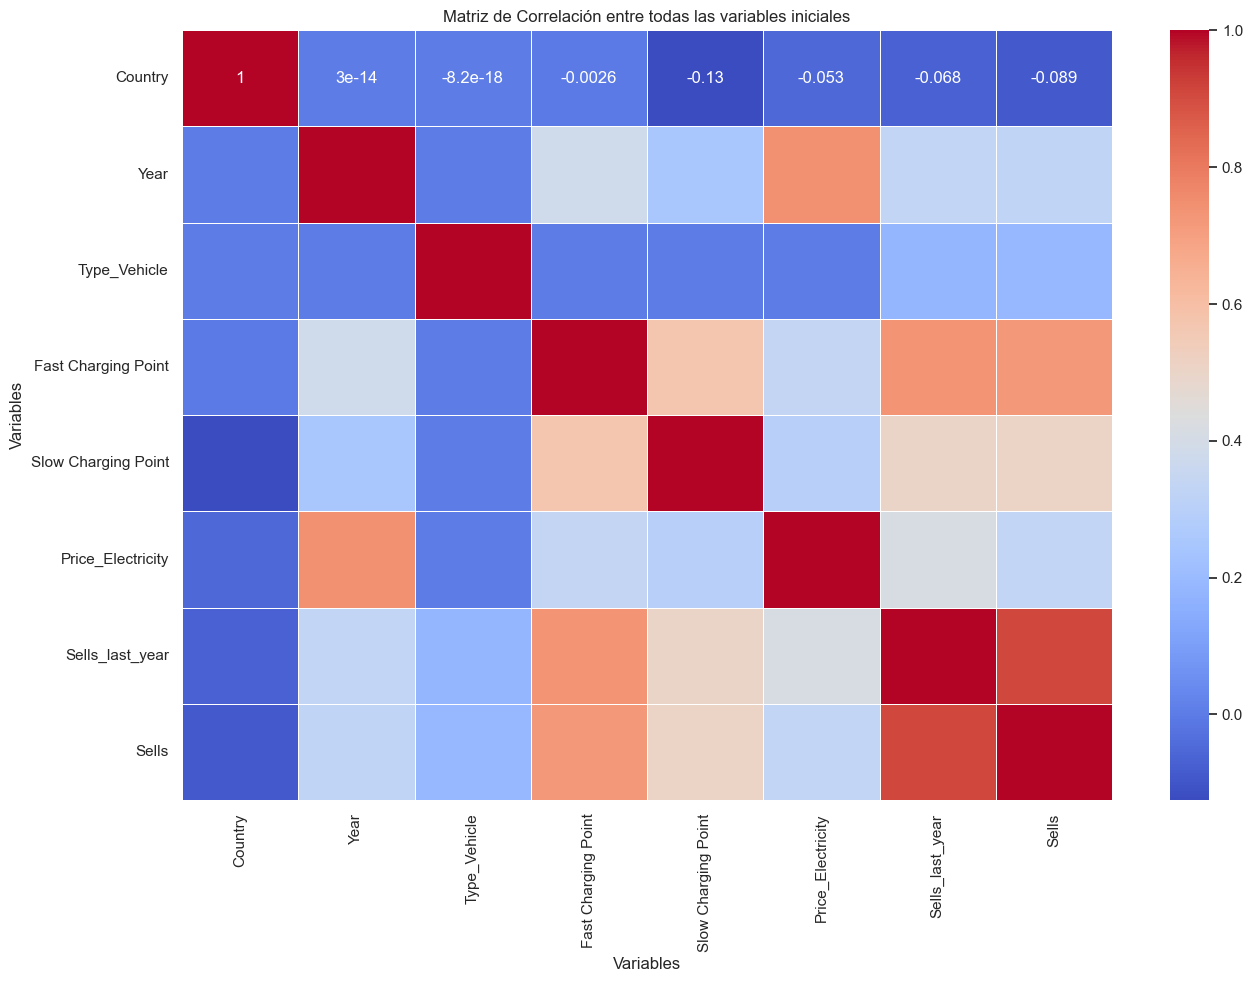

In [5]:
def analizar_correlacion(dataframe):
    correlation_matrix = dataframe.corr()
    sns.set(style="white")
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Matriz de Correlación entre todas las variables iniciales")
    plt.xlabel("Variables")
    plt.ylabel("Variables")
    plt.show()

analizar_correlacion(dataframe_h3)

Una vez creada la tarjeta de datos que utilizaremos, procederemos a realizar un estudio de las correlaciones entre variables.
*   Como bien habíamos anunciado previamente, existe una fuerte correlación entre las ventas del año anterior (Sells_last_year) y Sells con un valor de 0.91.
*   Además, también tenemos una buena correlación con los puntos de carga rápida, esto nos indica que este factor es relevante en la decisión de los clientes a la hora de decantarse por la compra de un vehículo eléctrico.

*   Aunque con una correlación mucho más débil que los puntos de carga rápida, los puntos de carga lenta tienen cierta correlación con las ventas

*   El precio de la luz no tiene tanta correlación con la compra de vehículos. Esto puede deberse a que entre los países que estudiamos apenas hay diferencias en el precio de la luz que lleven a decantarse por este modelo de vehículo.

*   Por último, el país, el tipo de vehículo y el año no estan correlacionadas con las ventas. Estos valores son de control para que conozcamos el contexto del resto de los datos, era esperable que no fuera a existir demasiada correlación.

### Selección de variables

Debido a que estamos en la obligación de quedarnos con todas las columnas, ya que esta hipótesis trata de la comprobación de la influencia de las condiciones para afrontar los vehículos eléctricos en un país, no podemos descartar columnas que apenas tienen correlación como pueden ser la del precio de la electricidad.
Sin embargo, si descartaremos el año. El año solamente representa información de cara al control, además de que apenas tiene correlación y debido a que queremos tener un modelo atemporal y tenemos un valor de referencia para que el análisis funcione como son las ventas en el año anterior, podemos descartarla sin problema. 

In [6]:
selected_columns = ["Country", "Type_Vehicle", "Fast Charging Point", "Slow Charging Point" , "Price_Electricity", "Sells_last_year"]

## Modelos

A la hora de querer realizar una predicción con los datos que tenemos, lo primero y más importante es decidir que tipo de modelo queremos realizar. En los modelos supervisados tenemos regresión y clasificación, mientras que en los no supervisados tenemos la clusterización. 

Este último tipo se ha descartado por dos motivos, al querer predecir el número de ventas, realizar agrupamientos de los datos no nos proporcionaría información de interés para nuestro objetivo y además, queremos tratar de incluir distintos modelos vistos en la asignatura, de ese modo, sabiendo que ya hay líneas de trabajo que tratan de la clusterización, se descarta. En los modelos no supervisados, se descarta la clasificación, la explicación es la misma que en el anterior punto, una clasificación no será de interés en este punto ya que lo que se trata de predecir es un valor. 

Por tanto, el modelo que se ha elegido es el de regresión. Dentro de los modelos de regresión vistos existen distintos tipos, RandomForest, DecisionTree, Redes Neuronales, kNN…

Las redes neuronales se han descartado debido a la falta de datos en el proyecto. Este tipo de modelo funciona muy bien en los casos en los que tienes una gran cantidad de datos, lo cuál te lleva a poder crear más capas y por tanto tener un modelo más robusto. 

Por último, nos queda RandomForest, DecisionTree y kNN. Trataremos de probar todos los modelos ya que cada uno tiene características distintas que serán interesantes de tratar.

### kNN

kNN funciona cuando tus datos son valores continuos, en este caso, salvo dos variables: el tipo de vehículo y el país, el resto de variables son continuas y además, como ya se ha comentado, forman una serie temporal. Además, kNN no es tan efectivo cuando tenemos una gran dimensionalidad en nuestros datos, en este caso no ocurre. Queremos comprobar si kNN es capaz de detectar en estos casos esa progresión de la que hablamos que existe en las ventas de un año al siguiente.

### DecisionTree y RandomForest 

DecisionTree y RandomForest implementan sistemas parecidos que además funcionan bien cuando no tenemos la suficiente cantidad de datos. RandomForest es una extensión de DecisionTree por lo que podremos comprobar las diferencias en las predicciones de ambos modelos.

## Pruebas

Queremos comprobar, no solo la eficiencia del modelo si no su aplicación en el mundo real. Es por ello, que definiremos casos de ventas para el año 2023 con datos que encontremos en diversas fuentes de información. Los países sobre los que haremos un estudio serán España, Alemania y Francia.

1. España: predicción de ventas de vehículo híbrido en 2023
    *   Ventas de vehículos: **300.000** (entre enero y junio fueron 150.000, suponemos el doble) [ANFAC](https://cincodias.elpais.com/companias/2023-07-05/estos-son-los-coches-hibridos-mas-vendidos-en-2023-ya-suponen-un-30-de-las-matriculaciones.html)
    *   Puntos de carga: [RACE](https://www.race.es/donde-encontrar-puntos-carga-coche-electrico#:~:text=Seg%C3%BAn%20el%20presidente%20de%20ANFAC,son%20puntos%20de%20recarga%20lentos.)
        * Puntos de carga rápida: 3400
        * Puntos de carga lenta: 13600

2.  Alemania: predicción de ventas de vehículo eléctrico en 2023
    *   Ventas de vehículos: **440.000** (entre enero y junio fueron 220.000, suponemos el doble) [KBA](https://www.electromaps.com/es/blog/ventas-vehiculos-electricos-europa-primer-semestre-2023#:~:text=Ca%C3%ADda%20del%2043%2C1%25%20de,total%20de%201.396.717%20unidades.)
    *   Puntos de carga: [Agencia Federal de Redes](https://tageblatt.com.ar/auto-electrico-arrasa-desafia-alemania-debe-suspender-su-plan-subvenciones/)
        * Puntos de carga rápida: 18500
        * Puntos de carga lenta: 79000

3.  Francia: predicción de ventas de vehículo eléctrico en 2023
    *   Ventas de vehículos: **274.000** (entre enero y junio fueron 137.000, suponemos el doble) [Plateforme automobile](https://www.electromaps.com/es/blog/ventas-vehiculos-electricos-europa-primer-semestre-2023#:~:text=Ca%C3%ADda%20del%2043%2C1%25%20de,total%20de%201.396.717%20unidades.)
    *   Puntos de carga: [AVERE](https://mobilityportal.lat/carga-francia-primer-semestre/)
        * Puntos de carga rápida: 13700
        * Puntos de carga lenta: 88200




In [7]:
def prediccion_prueba_spain(modelos):
    prueba = {
        "Country":             [12],    
        "Type_Vehicle":        [1], 
        "Fast Charging Point": [3400],  
        "Slow Charging Point": [13600], 
        "Price_Electricity":   [91],    
        "Sells_last_year":     [205980]
    }
    d = pd.DataFrame(prueba)

    for modelo in modelos:
        prediccion = modelo.predict(d)
        print("Valor españa: " + str(prediccion))

def prediccion_prueba_germany(modelos):
    prueba = {
        "Country":             [5],    
        "Type_Vehicle":        [0], 
        "Fast Charging Point": [18500],  
        "Slow Charging Point": [79000], 
        "Price_Electricity":   [101],    
        "Sells_last_year":     [417377]
    }
    d = pd.DataFrame(prueba)

    for modelo in modelos:
        prediccion = modelo.predict(d)
        print("Valor alemania: " + str(prediccion))

def prediccion_prueba_france(modelos):
    prueba = {
        "Country":             [4],    
        "Type_Vehicle":        [0], 
        "Fast Charging Point": [13700],  
        "Slow Charging Point": [88200],  
        "Price_Electricity":   [102],    
        "Sells_last_year":     [188721]
    }
    d = pd.DataFrame(prueba)

    for modelo in modelos:
        prediccion = modelo.predict(d)
        print("Valor Francia: " + str(prediccion))


## Entrenamiento

Debemos definir un mecanismo de entrenamiento para todos los modelos. Existen distintas formas: RandomizedSearch, GridSearch, librerías como optuna…. Tenemos 3 modelos y 3 librerías para entrenar el modelo, por tanto, utilizaremos una para cada una, así, veremos las distintas maneras de entrenar el modelo. Además, debemos establecer un número de iteraciones, de manera que podamos establecer en un tiempo computacional relativamente bajo el mejor modelo encontrado. 

1.  En randomizedSearch estableceremos una serie de valores con 1000 iteraciones y 5 de valor para cv (cross-validation). Tomaremos los 3 mejores resultados.
2.  En GridSearch, realizaremos todas las iteraciones, se ha establecido una serie de valores cuya combinación da 5440 iteraciones y 5 de valor para cv. Tomaremos los 3 mejores resultados
3.  En optuna estableceremos un valor de 5000 iteraciones y un timeout de 45 minutos. 


Existen distintas maneras para evaluar el entrenamiento que se realiza con los datos. Entre las métricas para el entrenamiento se encuentran precisión, área bajo la curva, …error cuadrático medio.
Teniendo en cuenta que tenemos un problema de regresión y que será muy complicado acertar el valor exacto, la precisión no será un buen indicador.  
El área bajo la curva es una métrica enfocada en problemas de clasificación, por lo que no nos será de interés. 

Por último, el error cuadrático medio será un indicador claro para encontrar el mejor modelo. En problemas de regresión, nos es de utilidad saber que modelo se queda más cerca de encontrar la solución y eso es lo que nos ofrece esta métrica.


### RandomForest -> RandomizedSearch

In [8]:
def RandomizedSearch(X_train, y_train):
    param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000],
    'max_depth': [20, 30,40, 50, 70, 90],
    'min_samples_split': [4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [5, 7, 9, 10, 12, 14],
    'max_features': ['sqrt', 'log2', 5, 7, 10, 12, 15, 20, 30, 40, 50]
    }
    regressor = RandomForestRegressor()
    random_search = RandomizedSearchCV(
        regressor,
        verbose=2,
        param_distributions=param_dist,
        n_iter=1000,
        scoring='neg_mean_squared_error',
        cv=5
    )
    random_search.fit(X_train, y_train)

    results_df = pd.DataFrame(random_search.cv_results_)
    sorted_results = results_df.sort_values(by="rank_test_score", ascending=False)
    top3_results = sorted_results.head(3)
    best_results = []
    print("Top 3 Mejores Resultados:")
    for i, (_, row) in enumerate(top3_results.iterrows(), 1):
        print(f"Modelo {i} - Hiperparámetros: {row['params']}, Score: {row['mean_test_score']}")
        regressor = RandomForestRegressor(**row["params"])
        regressor.fit(X_train, y_train)
        best_results.append(regressor)
    return best_results

### DecisionTree -> GridSearch

In [9]:
def GridSearch(X_train, y_train):
    param_dist = {
    'criterion': [ 'absolute_error','squared_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 11, 15],
    'min_samples_split': [2, 3, 5, 7, 12],
    'min_samples_leaf':  [1,3, 5, 7, 12],
    'max_features': ['sqrt', 'log2', 0.1, 0.4, 0.6, 0.8],
    }

    regressor = DecisionTreeRegressor()
    grid_search = GridSearchCV(
        regressor,
        verbose=1,
        param_grid=param_dist,
        scoring='neg_mean_squared_error',
        cv=5,

    )
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)
    sorted_results = results_df.sort_values(by="rank_test_score", ascending=True)
    top3_results = sorted_results.head(3)
    best_results = []
    print("Top 3 Mejores Resultados:")
    for i, (_, row) in enumerate(top3_results.iterrows(), 1):
        print(f"Modelo {i} - Hiperparámetros: {row['params']}, Score: {row['mean_test_score']}")
        regressor = DecisionTreeRegressor(**row["params"])
        regressor.fit(X_train, y_train)
        best_results.append(regressor)
    return best_results

### kNN -> Optuna

In [10]:
def objective(trial, x_train, x_test, y_train, y_test):
    param_dist = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),  # Aumentar el rango
        'p': trial.suggest_categorical('p', [1, 2]),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'chebyshev']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 5, 50),  # Aumentar el rango
    }

    regressor = KNeighborsRegressor(**param_dist)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

def optuna_search(x_train, x_test, y_train, y_test):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')
    objective_partial = lambda trial: objective(trial, x_train, x_test, y_train, y_test)
    study.optimize(objective_partial, n_trials=20000, timeout=1800, show_progress_bar=True)

    print("Mejores hiperparámetros:")
    best_regressors = []
    regressor = KNeighborsRegressor(**study.best_params)
    regressor.fit(x_train, y_train)
    best_regressors.append(regressor)  

    return best_regressors

### Procedimiento

Una vez hemos definido el procedimiento para entrenar cada patrón y las pruebas de evaluación, solo queda dejar que la computadora trabaje y esperar sus resultados para su posterior análisis.

In [11]:
def entrenar_modelo(df, selected_columns, tipo):
    X = df[selected_columns]
    y = df['Sells']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if tipo=='kNN':
        regressor = optuna_search(x_train, x_test, y_train, y_test)
    elif tipo == 'RandomForest':
        regressor = RandomizedSearch(x_train, y_train)
    elif tipo == 'DecissionTree':
        regressor = GridSearch(x_train, y_train)
        
    return regressor

def resultados_modelo(df):
    for tipo in ['kNN', 'RandomForest', 'DecissionTree']:
        modelos = entrenar_modelo(df, selected_columns, tipo)
        print(f"TIPO DE REGRESOR: {tipo}")
        prediccion_prueba_spain(modelos)
        prediccion_prueba_germany(modelos)
        prediccion_prueba_france(modelos)

## Resultados

Una vez entrenado el modelo y habiendo contemplado los resultados,construiremos un gráfico de barras indicando los resultados obtenidos, para que así podamos terminar las conclusiones.

Best trial: 5267. Best value: 1.35361e+08:  53%|██████████████████████▊                    | 10625/20000 [45:00<39:42,  3.93it/s, 2700.39/2700 seconds]
Mejores hiperparámetros:
TIPO DE REGRESOR: kNN
Valor españa: [152986.16216216]
Valor alemania: [182759.]
Valor Francia: [142031.91891892]
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Top 3 Mejores Resultados:
Modelo 1 - Hiperparámetros: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 20}, Score: -6910807510.883278
Modelo 2 - Hiperparámetros: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 50}, Score: -6844217930.167097
Modelo 3 - Hiperparámetros: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 50}, Score: -6805948910.349187
TIPO DE REGRESOR: RandomForest
Valor españa: [136693.79052738]
Valor españa: [163570.36754014]
Valor españa: [150324.58050768]
Valor alemania: [260090.04641199]
Valor alemania: [258386.80281477]
Valor alemania: [258416.57646535]
Valor Francia: [260076.94910377]
Valor Francia: [258558.00200708]
Valor Francia: [258676.25537256]
Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
Top 3 Mejores Resultados:
Modelo 1 - Hiperparámetros: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.6, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'best'}, Score: -3009924527.0308394
Modelo 2 - Hiperparámetros: {'criterion': 'poisson', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 7, 'splitter': 
'best'}, Score: -3126938507.822707
Modelo 3 - Hiperparámetros: {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 7, 'splitter': 'random'}, Score: -3151705689.4137936
TIPO DE REGRESOR: DecissionTree
Valor españa: [305934.]
Valor españa: [155219.125]
Valor españa: [171655.16666667]
Valor alemania: [543358.33333333]
Valor alemania: [548208.28571429]
Valor alemania: [305519.8]
Valor Francia: [334358.33333333]
Valor Francia: [249208.28571429]
Valor Francia: [305519.8]

In [12]:
def dibujar_grafico(nombres, valores, pais, valor_esperado):

    plt.axhline(y=valor_esperado, color='black', linestyle='--', linewidth=2, label='Valor esperado')
    plt.bar(nombres, valores)
    # Añadir etiquetas y título
    plt.xlabel('Modelo')
    plt.ylabel('Ventas')
    plt.title('Ventas ' + pais)
    # Mostrar el gráfico
    plt.show()

nombres = ['kNN', 'Random\nForest 1', 'Random\nForest 2', 'Random\nForest 3', 'Decission\nTree 1', 'Decission\nTree 2', 'Decission\nTree 3']


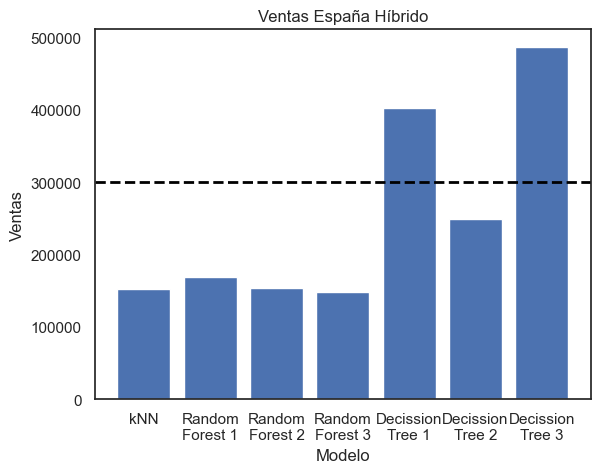

In [13]:
valores_esp = [152000, 169000, 153000, 148000, 402000, 249000, 487000]
dibujar_grafico(nombres, valores_esp, 'España Híbrido', 300000)

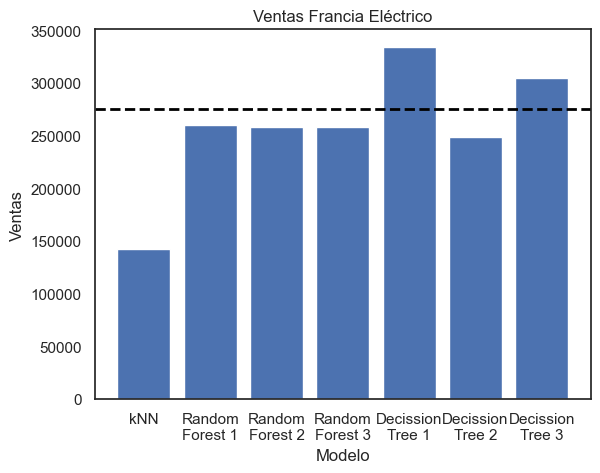

In [14]:
valores_fr = [142000, 260000, 258000, 258000, 334000, 249000, 305000]
dibujar_grafico(nombres, valores_fr, 'Francia Eléctrico', 275000)

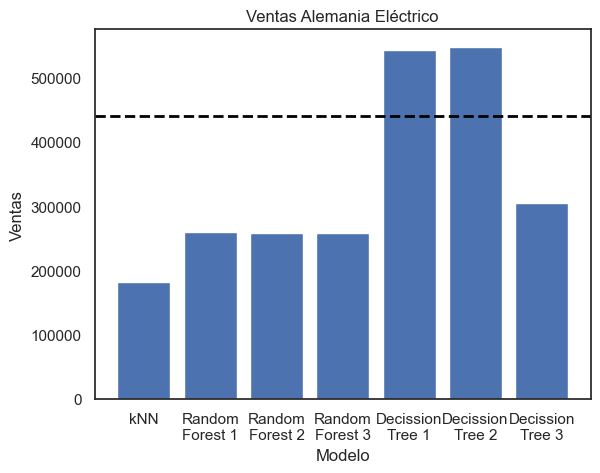

In [16]:
valores_ger = [182000, 260000, 258000, 258000, 543000, 548000, 305000]
dibujar_grafico(nombres, valores_ger, 'Alemania Eléctrico', 440000)

## Análisis

Una vez expuestos los resultados, podemos proceder a un análisis de los resultados. 
Si midiéramos los resultados por el valor obtenido por el error cuadrático medio, podríamos pensar que lo que hemos hecho da lugar a un modelo que es incapaz de predecir ningún dato.
Sin embargo, hay que pensar que los valores de las ventas con las que estamos tratando son muy grandes por lo que un valor grande no representa exactamente que el modelo sea poco fiable. Sin embargo, si podemos comparar los modelos entre sí en base a dicho valor. 

Primero, podemos ver la diferencia entre usar GridSearch y RandomizedSearch (con optuna no hemos obtenido el error para el mejor modelo), el error cuadrático medio que encontramos en GridSearch es mucho menor que en RandomizedSearch. Es algo que se puede considerar obvio, se puede explicar por el mayor tiempo de cómputo para crear este modelo, que al explorar más soluciones es capaz de encontrar mejores opciones, en GridSearch se han realizado 27000 iteraciones y en RandomizedSearch apenas 5000.

En segunda instancia, podemos comprobar lo fiable que es el modelo en base a los casos de prueba que se han generado para España, Alemania y Francia. 
Estos casos han sido generados en base a información encontrada en distintos medios de comunicación y, si bien son estimaciones en base a datos recopilados hasta el momento en el año (por ejemplo las ventas de coches desde enero hasta junio), puede servir como indicativo de lo fiable que es nuestro modelo.
En este caso, predomina DecissionTree, el cual vemos en los gráficos que se queda más cerca por lo general de la línea horizontal divisoria que representa el valor esperado para cada país. 

Además, sorprende el hecho de que kNN sea un modelo que genere un error porcentual absoluto medio tan elevado en comparación al resto de modelos. Es posible que se deba a las características irrelevantes para su entrenamiento, el precio de la luz, con apenas correlación puede haber sido un impedimento para obtener mejores resultados. Otro factor puede haber sido el problema de tener muchos países que venden muy pocas unidades de vehículos eléctricos, países como Grecia o Austria venden pocas unidades en comparación con Alemania o Francia, por extensión del terreno y por condiciones económicas. 

Sin embargo, debemos cuantificar estos valores, en la siguiente tabla, mostraremos otra métrica que es más comprensible para el usuario y que se puede combinar con el error cuadrático medio, en este caso el error porcentual absoluto medio.


| Modelo       | Error porcentual absoluto medio
|--------------|--------------|
| kNN               |  52%    |
| RandomForest 1    |  30%    |
| RandomForest 2    |  32%    |
| RandomForest 3    |  32%    |
| DecissionTree 1   |  26%    | 
| DecissionTree 2   |  17%    |
| DecissionTree 3   |  34%    |


Finalmente, hemos conseguido obtener un modelo con un 17% de variación con el valor real. Puede parecer poco, pero tomando en consideración el proyecto propuesto, la poca cantidad de datos y la dificultad en su obtención, nos lleva a pensar que una empresa capaz de conseguir un dataset con mayores registros de ventas de coches y agregandole algunos datos más, sería capaz de obtener un buen modelo que le otorgue la información de cara a su planificación empresarial, tendrá una gran ventaja con sus rivales al saber el crecimiento del sector.